In [339]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import numpy as np
import random
from scipy import interpolate
from scipy.spatial import ConvexHull
import math
from seaborn import light_palette



from functions import triangle_func

In [340]:
class FuzzySet:
    def __init__(self, func, func_params, is_out=False):
        self.func = func
        self.func_params = func_params
        self.set_func_values(func, func_params, is_out)

    def set_func_values(self, func, params, is_out, e=0.0005):
        if is_out:
            y_range = []
            x_range = np.arange(0.0, 1+e, e)
            for x in x_range:
                y_range.append(func(params, x))

            self.x_range = x_range
            self.y_range = y_range

        else:
            self.x_range = None
            self.y_range = None

    def set_alpha(self, alpha):
        if self.y_range is not None:
            y_range = self.y_range
            self.y_range = [min(y, alpha) for y in y_range]

    def set_extra_points(self, alpha):
        max_x = -1
        min_x = np.inf
        extra_points = []
        for i in range(len(self.x_range)):
            if self.y_range[i] == alpha and self.x_range[i] > max_x:
                max_x = self.x_range[i]
            if self.y_range[i] == alpha and self.x_range[i] < min_x:
                min_x = self.x_range[i]

        extra_points.append([round(float(max_x), 2), round(float(alpha), 2)])
        extra_points.append([round(float(min_x), 2), round(float(alpha), 2)])
        return extra_points

In [ ]:
class RuleParser:
    def __init__(self, rules_file='rules.json'):
        with open(rules_file, 'r', encoding='utf-8') as f:
            rules_data = json.load(f)

        self.rules_data = rules_data['db_quality_rules']
        self.input_terms = ['мало', 'средне', 'много']
        self.output_terms = ['очень_плохое', 'плохое', 'нормальное', 'хорошее', 'очень_хорошее']
        self.oo_min = 0.0
        self.oo_max = 1.0
    
        self.composite_pk = {
            'мало': FuzzySet(
                func=triangle_func,
                func_params=[0.0, 0.15, 0.3]
            ),
            'средне': FuzzySet(
                func=triangle_func,
                func_params=[0.25, 0.3, 0.5]
            ),
            'много': FuzzySet(
                func=triangle_func,
                func_params=[0.4, 0.6, 1.0]
            )
        }

        self.not_int_pk = {
            'мало': FuzzySet(
                func=triangle_func,
                func_params=[0.0, 0.15, 0.3]
            ),
            'средне': FuzzySet(
                func=triangle_func,
                func_params=[0.25, 0.3, 0.5]
            ),
            'много': FuzzySet(
                func=triangle_func,
                func_params=[0.4, 0.6, 1.0]
            )
        }

        # self.complex_attr = {
        #     'мало': FuzzySet(
        #         func=triangle_func,
        #         func_params=[0, 0.05, 0.1]
        #     ),
        #     'средне': FuzzySet(
        #         func=triangle_func,
        #         func_params=[0.08, 0.15, 0.2]
        #     ),
        #     'много': FuzzySet(
        #         func=triangle_func,
        #         func_params=[0.15, 0.2, 1.0]
        #     )
        # }

        self.memory_waste_char = {
            'мало': FuzzySet(
                func=triangle_func,
                func_params=[0, 0.05, 0.1]
            ),
            'средне': FuzzySet(
                func=triangle_func,
                func_params=[0.08, 0.15, 0.2]
            ),
            'много': FuzzySet(
                func=triangle_func,
                func_params=[0.15, 0.2, 1.0]
            )
        }

        self.fnpz_tbl = {
            'мало': FuzzySet(
                func=triangle_func,
                func_params=[0, 0.05, 0.1]
            ),
            'средне': FuzzySet(
                func=triangle_func,
                func_params=[0.08, 0.15, 0.2]
            ),
            'много': FuzzySet(
                func=triangle_func,
                func_params=[0.15, 0.2, 1.0]
            )
        }

        self.trz_tbl = {
            'мало': FuzzySet(
                func=triangle_func,
                func_params=[0, 0.05, 0.1]
            ),
            'средне': FuzzySet(
                func=triangle_func,
                func_params=[0.08, 0.15, 0.2]
            ),
            'много': FuzzySet(
                func=triangle_func,
                func_params=[0.15, 0.2, 1.0]
            )
        }

        self.default_upd = {
            'мало': FuzzySet(
                func=triangle_func,
                func_params=[0.0, 0.1, 0.15]
            ),
            'средне': FuzzySet(
                func=triangle_func,
                func_params=[0.08, 0.2, 0.4]
            ),
            'много': FuzzySet(
                func=triangle_func,
                func_params=[0.3, 0.5, 1.0]
            )
        }

        self.default_del = {
            'мало': FuzzySet(
                func=triangle_func,
                func_params=[0.0, 0.1, 0.15]
            ),
            'средне': FuzzySet(
                func=triangle_func,
                func_params=[0.08, 0.2, 0.4]
            ),
            'много': FuzzySet(
                func=triangle_func,
                func_params=[0.3, 0.5, 1.0]
            )
        }


        self.quality = {
            'очень_плохое': FuzzySet(
                func=triangle_func,
                func_params=[0.0, 0.15, 0.3],
                is_out=True
            ),
            'плохое': FuzzySet(
                func=triangle_func,
                func_params=[0.25, 0.3, 0.35],
                is_out=True
            ),
            'нормальное': FuzzySet(
                func=triangle_func,
                func_params=[0.32, 0.4, 0.48],
                is_out=True
            ),
            'хорошее': FuzzySet(
                func=triangle_func,
                func_params=[0.4, 0.5, 0.6],
                is_out=True
            ),
            'очень_хорошее': FuzzySet(
                func=triangle_func,
                func_params=[0.55, 0.75, 1.0],
                is_out=True
            )
        }


        self.all_fuzzy_sets = {
            'доля_составных_ключей': self.composite_pk,
            'доля_не_целочисленных_ключей': self.not_int_pk,
            'доля_char_атрибутов_с_растратой_пямяти': self.memory_waste_char,
            'доля_таблиц_без_on_update': self.default_upd,
            'доля_таблиц_без_on_delete': self.default_del,
            'качество': self.quality
        }

    def parse_rule(self, rule_data):
        rule = rule_data['rule']
        weight = rule_data['weight']
        rule = rule.strip().lower()
        pattern = r'если\s+([a-яё_\s]+?)\s+[–-]\s+([a-яё_\s]+?),?\s+то\s+([a-яё_\s]+?)\s+[–-]\s+([a-яё_\s]+?)$'
        
        match = re.match(pattern, rule)
        
        if not match:
            print(f"Ошибка парсинга правила: {rule}")
            return None, None, None, None
        
        input_var = match.group(1).strip()
        input_term = match.group(2).strip() 
        output_var = match.group(3).strip()
        output_term = match.group(4).strip()

        return input_var, input_term, output_var, output_term, weight

    def parse_rule_with_and(self, rule_data):
        rule = rule_data['rule']
        weight = rule_data['weight']
        rule = rule.strip().lower()
        main_pattern = r'если\s+(.+?)\s+то\s+(.+?)$'
        
        main_match = re.match(main_pattern, rule)
        
        if not main_match:
            return {
                'is_valid': False,
                'conditions': [],
                'output_var': None,
                'output_term': None,
                'error': f"Ошибка парсинга основной структуры правила: {rule}"
            }
        
        conditions_str = main_match.group(1)  # "параметр1 – терм1 И параметр2 – терм2 И ..."
        output_str = main_match.group(2)      # "качество – терм"
        
        # Разделяем по оператору И
        condition_parts = re.split(r'\s+и\s+', conditions_str)
        
        conditions = []
        
        # Паттерн для одного условия: "параметр – терм" или "параметр - терм"
        condition_pattern = r'([a-яё_\s]+?)\s+[–-]\s+([a-яё_\s]+?)$'
        
        for condition_part in condition_parts:
            condition_part = condition_part.strip()
            
            match = re.match(condition_pattern, condition_part)
            
            if not match:
                return {
                    'is_valid': False,
                    'conditions': [],
                    'output_var': None,
                    'output_term': None,
                    'error': f"Ошибка парсинга условия: '{condition_part}'"
                }
            
            param = match.group(1).strip()
            term = match.group(2).strip()
            
            conditions.append({
                'parameter': param,
                'term': term
            })

        output_pattern = r'([a-яё_\s]+?)\s+[–-]\s+([a-яё_\s]+?)$'
        output_match = re.match(output_pattern, output_str)
        
        if not output_match:
            return {
                'is_valid': False,
                'conditions': conditions,
                'output_var': None,
                'output_term': None,
                'error': f"Ошибка парсинга выхода: '{output_str}'"
            }
        
        output_var = output_match.group(1).strip()
        output_term = output_match.group(2).strip()
        
        return {
            'is_valid': True,
            'conditions': conditions,
            'output_var': output_var,
            'output_term': output_term,
            'weight': weight,
            'error': None
        }

    # построение матриц

    def build_matrices_from_parsed_rules(self, parsed_rules):
            matrices = {}
            param_rules = {}
            
            for parsed in parsed_rules:
                if not parsed['is_valid']:
                    continue
                    
                conditions = parsed['conditions']
                if not conditions:
                    continue
            
                first_param = conditions[0]['parameter']
                
                if first_param not in param_rules:
                    param_rules[first_param] = {}
                
                first_term = conditions[0]['term']
                output_term = parsed['output_term']
                weight = parsed['weight'] or 1.0
                
                param_rules[first_param][first_term] = {
                    'output_term': output_term,
                    'weight': weight
                }
            
            for param_name, param_data in param_rules.items():
                matrix = np.zeros((len(self.input_terms), len(self.output_terms)))
                
                for i, input_term in enumerate(self.input_terms):
                    if input_term in param_data:
                        output_term = param_data[input_term]['output_term']
                        weight = param_data[input_term]['weight']
                        
                        if output_term in self.output_terms:
                            j = self.output_terms.index(output_term)
                            matrix[i, j] = weight
                
                matrices[param_name] = {
                    'input_terms': self.input_terms,
                    'output_terms': self.output_terms,
                    'matrix': matrix.tolist()
                }
            
            return matrices

    def get_relation_matrices(self):
            parsed_rules = []
            
            for rule_data in self.rules_data:
                parsed = self.parse_rule_with_and(rule_data)
                parsed_rules.append(parsed)
            
            matrices = self.build_matrices_from_parsed_rules(parsed_rules)
            return matrices

    def matrices_to_dataframes(self, matrices):
            dataframes = {}
            
            for param_name, data in matrices.items():
                input_terms = data['input_terms']
                output_terms = data['output_terms']
                matrix = np.array(data['matrix'])
                df = pd.DataFrame(
                    matrix,
                    index=input_terms,
                    columns=output_terms
                )
                df = df.round(2)
                
                dataframes[param_name] = df
            
            return dataframes

    def print_all_dataframes(self, dataframes):
                for param_name, df in dataframes.items():
                    print(f"{param_name}")
                    print(df)
                    print()

    def visualize_matrices(self, matrices, transposed=False, figsize=(15, 10)):
            n_matrices = len(matrices)
            fig, axes = plt.subplots(2, n_matrices//2 + n_matrices%2, figsize=figsize)
            if n_matrices == 1:
                axes = [axes]
            elif n_matrices == 2:
                axes = axes.reshape(1, -1)
            axes = axes.flatten()
            
            for idx, (param_name, data) in enumerate(matrices.items()):
                ax = axes[idx]
                
                if transposed:
                    sns.heatmap(
                        data['matrix'],
                        annot=True, fmt='.2f',
                        cmap=light_palette('blue'),
                        ax=ax,
                        xticklabels=self.input_terms,
                        yticklabels=self.output_terms,
                        vmin=0, vmax=1
                    )
                    ax.set_xlabel(f'{param_name.replace('_', ' ')}', fontsize=12, fontweight='bold')
                    ax.set_ylabel('Термы качества', fontsize=12, fontweight='bold')

                else:
                    sns.heatmap(
                        data['matrix'],
                        annot=True, fmt='.2f',
                        cmap=light_palette('blue'),
                        ax=ax,
                        xticklabels=self.output_terms,
                        yticklabels=self.input_terms,
                        vmin=0, vmax=1
                    )
                
                    ax.set_ylabel(f'{param_name.replace('_', ' ')}', fontsize=12, fontweight='bold')
                    ax.set_xlabel('Качество', fontsize=12, fontweight='bold')
            
            # Убираем лишние subplot'ы
            for i in range(n_matrices, len(axes)):
                fig.delaxes(axes[i])
            
            plt.tight_layout()
            plt.show()

    # def visualize_single_matrix(self, param_name: str, matrix_data):

    def parse_conjunction_rule(self, rule_data):
        rule_text = rule_data['rule'].lower().strip()
        weight = rule_data.get('weight', 1.0)
        
        input_terms = ['мало', 'средне', 'много']
        output_terms = ['очень_плохое', 'плохое', 'нормальное', 'хорошее', 'очень_хорошее']
        
        match = re.search(r'если\s+(.+?)\s+то\s+(.+?)$', rule_text)
        if not match:
            raise ValueError(f"Не удалось распарсить правило: {rule_text}")
        
        conditions_str = match.group(1)
        output_str = match.group(2)
        
        condition_parts = re.split(r'\s+и\s+', conditions_str)
        conditions = []
        param_names = []
        
        for part in condition_parts:
            cond_match = re.search(r'([\w_]+)\s+[–-]\s+([\w_]+)', part)
            if cond_match:
                param = cond_match.group(1).strip()
                term = cond_match.group(2).strip()
                conditions.append((param, term))
                param_names.append(param)
        
        if len(conditions) != 2:
            raise ValueError(f"Ожидается 2 условия, получено {len(conditions)}")
        
        output_match = re.search(r'([\w_]+)\s+[–-]\s+([\w_]+)', output_str)
        if not output_match:
            raise ValueError(f"Не удалось распарсить выход: {output_str}")
        
        output_term = output_match.group(2).strip()
        
        param1, term1 = conditions[0]
        param2, term2 = conditions[1]
        
        if term1 not in input_terms:
            raise ValueError(f"Терм '{term1}' не найден в {input_terms}")
        if term2 not in input_terms:
            raise ValueError(f"Терм '{term2}' не найден в {input_terms}")
        
        term1_idx = input_terms.index(term1)
        term2_idx = input_terms.index(term2)
        
        if output_term not in output_terms:
            raise ValueError(f"Выходной терм '{output_term}' не найден в {output_terms}")
        
        output_idx = output_terms.index(output_term)
        
        row_idx = term1_idx * 3 + term2_idx
        
        matrix = np.zeros((9, 5))
        matrix[row_idx, output_idx] = weight
        
        key = f"{param1}_И_{param2}"
        
        result = {
            key: {
                'param1': param1,
                'param2': param2,
                'input_terms': input_terms,
                'output_terms': output_terms,
                'matrix': matrix.tolist()
            }
        }
        
        return result

    def aggregate_rules(self, rules_data):
        aggregated = {}
        
        for rule_data in rules_data:
            try:
                parsed = self.parse_conjunction_rule(rule_data)
                
                for key, data in parsed.items():
                    if key not in aggregated:
                        aggregated[key] = data
                    else:
                        old_matrix = np.array(aggregated[key]['matrix'])
                        new_matrix = np.array(data['matrix'])
                        aggregated[key]['matrix'] = np.maximum(old_matrix, new_matrix).tolist()
            
            except ValueError as e:
                print(f"⚠️  {e}")
        
        return aggregated

    def matrix_to_dataframe(self, result):
        dataframes = {}
        
        for key, data in result.items():
            param1 = data['param1']
            param2 = data['param2']
            input_terms = data['input_terms']
            output_terms = data['output_terms']
            matrix = data['matrix']
            
            # Создаём индексы строк: все комбинации (param1, param2)
            row_index = []
            for t1 in input_terms:
                for t2 in input_terms:
                    row_index.append(f"({t1}, {t2})")
            
            # Создаём DataFrame
            df = pd.DataFrame(
                matrix,
                index=pd.Index(row_index, name=f"{param1} × {param2}"),
                columns=output_terms
            )
            
            dataframes[key] = df
        
        return dataframes

    def visualize_fuzzy_matrix(self, param_name, data, ax=None, figsize=(10, 10)):
        # Создаём новый axes если не передан
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
        
        # Проверяем, является ли data DataFrame или dict
        if isinstance(data, pd.DataFrame):
            # Работаем с DataFrame напрямую
            matrix_df = data
            matrix = matrix_df.values
            output_terms = matrix_df.columns.tolist()
            row_labels = matrix_df.index.tolist()
        else:
            # Работаем со словарём (старый формат)
            matrix = np.array(data['matrix']) if isinstance(data['matrix'], list) else data['matrix']
            output_terms = data.get('output_terms', ['очень_плохое', 'плохое', 'нормальное', 'хорошее', 'очень_хорошее'])
            input_terms = data.get('input_terms', ['мало', 'средне', 'много'])
            row_labels = [f"({input_terms[i]}, {input_terms[j]})" for i in range(3) for j in range(3)]
        
        # Визуализируем
        sns.heatmap(
            matrix,
            annot=True, fmt='.2f',
            cmap=light_palette('blue'),
            ax=ax,
            xticklabels=output_terms,
            yticklabels=row_labels,
            vmin=0, vmax=1,
            cbar_kws={'label': 'Вес'}
        )
        
        ax.set_ylabel(f'{param_name.replace("_", " ")}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Качество', fontsize=12, fontweight='bold')
        
        # Ротация меток осей
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
        
        return ax

    def matrix_composition(self, R: np.ndarray, S: np.ndarray) -> np.ndarray:
        R = np.array(R)
        S = np.array(S)
        
        # Транспонируем S: качество(5) → проблемы2(3)
        S_T = S.T  # 3×5 → 5×3
        
        # Проверяем совместимость: R столбцы == S_T строки
        if R.shape[1] != S_T.shape[0]:
            raise ValueError(f"Несовместимые размеры: R{ R.shape }, S_T{ S_T.shape }")
        
        m, n = R.shape      # m=3, n=5
        n2, p = S_T.shape   # n2=5, p=3
        
        P = np.zeros((m, p))
        
        # Классический цикл "строкой на столбец"
        for i in range(m):
            for j in range(p):
                # min по k: строка R[i] × столбец S_T[:,j]
                candidates = np.minimum(R[i, :], S_T[:, j])
                P[i, j] = np.max(candidates)
        
        return P
    
    def fuzzify_composition_result(self, weigth):
        membership = 0
        term = ''
        for k, v in self.quality.items():
            self.quality[k] 
            cur_membership = self.quality[k].func(self.quality[k].func_params, weigth)
            if cur_membership > membership:
                term = k
                membership = cur_membership

        return term, membership

    def generate_rules_from_composition(self, param1_name, param2_name, matrices, threshold=0.5):
        R = np.array(matrices[param1_name]['matrix'])
        S = np.array(matrices[param2_name]['matrix'])
        
        # Свёртка
        P = self.matrix_composition(R, S)
        rules = []
        
        for i in range(3):
            for j in range(3):
                weight = P[i, j]
                term, membership = self.fuzzify_composition_result(weight)
                if weight >= threshold:
                    rule = f"ЕСЛИ {param1_name} – {self.input_terms[i]} И {param2_name} – {self.input_terms[j]} ТО качество – {term}"
                    rules.append({'rule': rule, 'weight': membership})
        
        return {
            'composition_matrix': P.tolist(),
            'rules': rules,
            'threshold': threshold
        }
    
    def transpose_relation_matrix(self, matrix_data) :
        matrix = np.array(matrix_data['matrix'])
        
        return {
            'input_terms': matrix_data['output_terms'], 
            'output_terms': matrix_data['input_terms'], 
            'matrix': matrix.T.tolist() 
        }

    def transpose_all_matrices(self, matrix):
        transposed_matrices = {}
        
        for param_name, matrix_data in matrix.items():
            transposed = self.transpose_relation_matrix(matrix_data)
            transposed_matrices[param_name] = transposed
    
        self.transposed_matrices = transposed_matrices
        return transposed_matrices

    def find_complement(self, fuzzy_set):
        operation: str = 'standard'
        
        is_series = isinstance(fuzzy_set, pd.Series)
        
        if is_series:
            fuzzy_dict = fuzzy_set.to_dict()
        else:
            fuzzy_dict = fuzzy_set.copy()
        
        complement = {}
        
        if operation == 'standard':
            for element, membership in fuzzy_dict.items():
                complement[element] = 1 - membership
        
        else:
            raise ValueError(f"Неизвестная операция: {operation}. ")
        
        if is_series:
            return pd.Series(complement)
        else:
            return complement


In [342]:
parser = RuleParser('rules_simple.json')

In [343]:
matrices = parser.get_relation_matrices()
matrices

{'доля_составных_ключей': {'input_terms': ['мало', 'средне', 'много'],
  'output_terms': ['очень_плохое',
   'плохое',
   'нормальное',
   'хорошее',
   'очень_хорошее'],
  'matrix': [[0.0, 0.0, 0.0, 0.0, 0.5],
   [0.0, 0.0, 0.6, 0.0, 0.0],
   [0.7, 0.0, 0.0, 0.0, 0.0]]},
 'доля_не_целочисленных_ключей': {'input_terms': ['мало', 'средне', 'много'],
  'output_terms': ['очень_плохое',
   'плохое',
   'нормальное',
   'хорошее',
   'очень_хорошее'],
  'matrix': [[0.0, 0.0, 0.0, 0.0, 0.6],
   [0.0, 0.0, 0.7, 0.0, 0.0],
   [0.8, 0.0, 0.0, 0.0, 0.0]]},
 'доля_char_атрибутов_с_растратой_пямяти': {'input_terms': ['мало',
   'средне',
   'много'],
  'output_terms': ['очень_плохое',
   'плохое',
   'нормальное',
   'хорошее',
   'очень_хорошее'],
  'matrix': [[0.0, 0.0, 0.0, 0.0, 0.75],
   [0.0, 0.0, 0.85, 0.0, 0.0],
   [0.95, 0.0, 0.0, 0.0, 0.0]]},
 'доля_таблиц_без_on_update': {'input_terms': ['мало', 'средне', 'много'],
  'output_terms': ['очень_плохое',
   'плохое',
   'нормальное',
   'хоро

In [344]:
dfs = parser.matrices_to_dataframes(matrices)
parser.print_all_dataframes(dfs)

доля_составных_ключей
        очень_плохое  плохое  нормальное  хорошее  очень_хорошее
мало             0.0     0.0         0.0      0.0            0.5
средне           0.0     0.0         0.6      0.0            0.0
много            0.7     0.0         0.0      0.0            0.0

доля_не_целочисленных_ключей
        очень_плохое  плохое  нормальное  хорошее  очень_хорошее
мало             0.0     0.0         0.0      0.0            0.6
средне           0.0     0.0         0.7      0.0            0.0
много            0.8     0.0         0.0      0.0            0.0

доля_char_атрибутов_с_растратой_пямяти
        очень_плохое  плохое  нормальное  хорошее  очень_хорошее
мало            0.00     0.0        0.00      0.0           0.75
средне          0.00     0.0        0.85      0.0           0.00
много           0.95     0.0        0.00      0.0           0.00

доля_таблиц_без_on_update
        очень_плохое  плохое  нормальное  хорошее  очень_хорошее
мало             0.0     0.0        

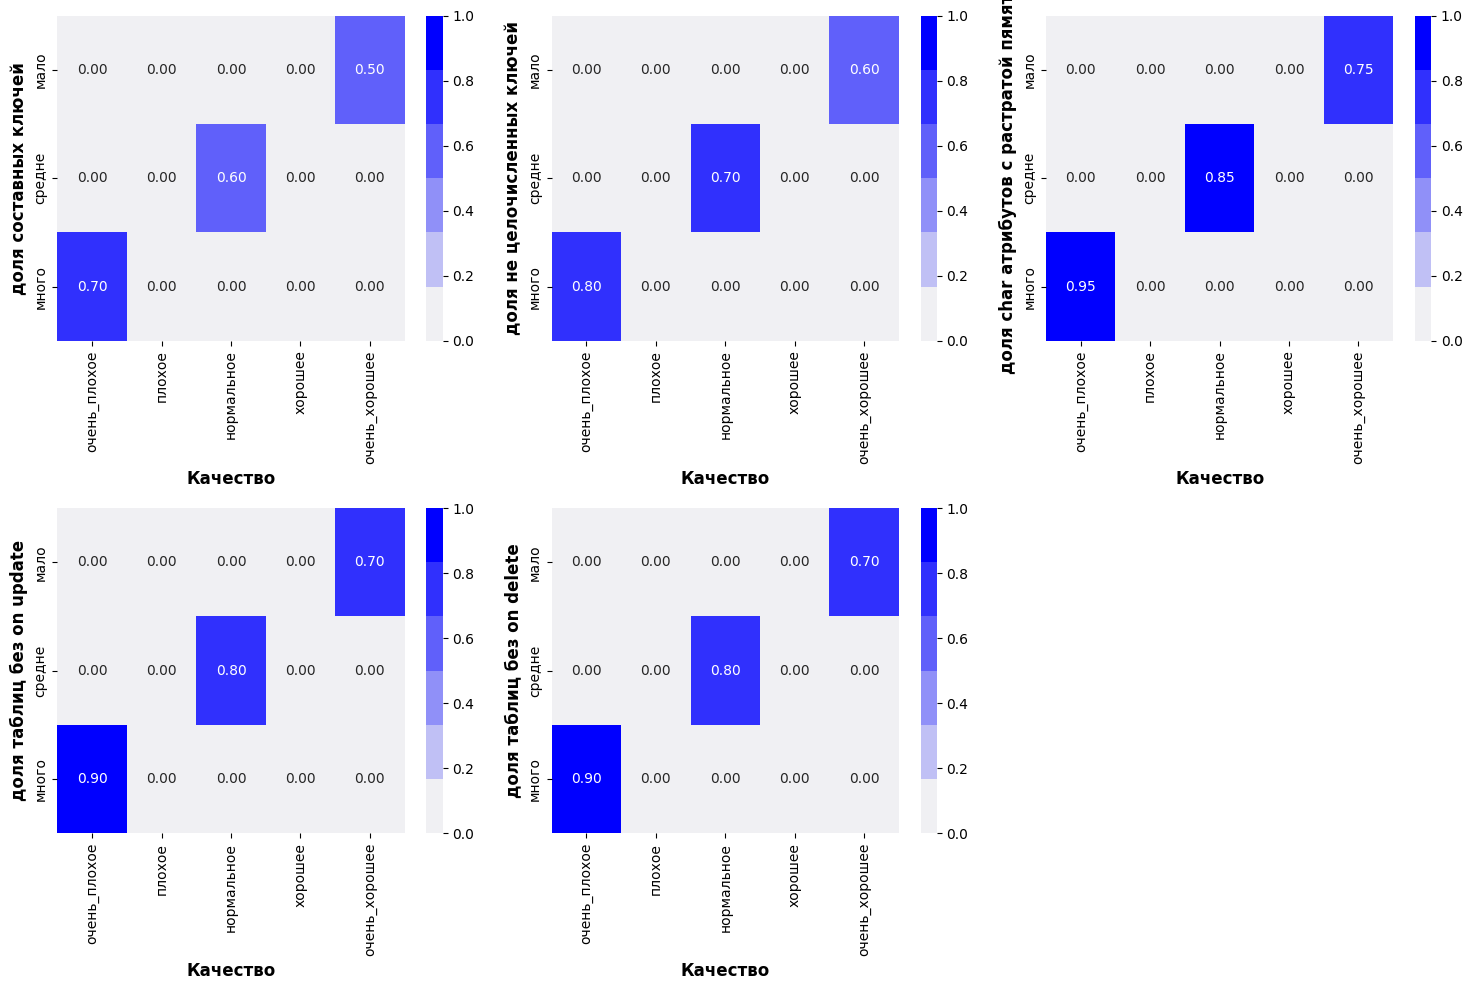

In [345]:
parser.visualize_matrices(matrices)

In [346]:
# Генерация правил
n1 = 'доля_составных_ключей'
n2 = 'доля_char_атрибутов_с_растратой_пямяти'
pair_result = parser.generate_rules_from_composition(n1, n2, matrices=matrices)

for rule in pair_result['rules']:
    print(rule)

{'rule': 'ЕСЛИ доля_составных_ключей – мало И доля_char_атрибутов_с_растратой_пямяти – мало ТО качество – хорошее', 'weight': 1.0}
{'rule': 'ЕСЛИ доля_составных_ключей – средне И доля_char_атрибутов_с_растратой_пямяти – средне ТО качество – очень_хорошее', 'weight': 0.25}
{'rule': 'ЕСЛИ доля_составных_ключей – много И доля_char_атрибутов_с_растратой_пямяти – много ТО качество – очень_хорошее', 'weight': 0.75}


In [347]:
rules_data = pair_result['rules']

conjuction_matrices = parser.aggregate_rules(rules_data)
conjuction_matrices_df = parser.matrix_to_dataframe(conjuction_matrices)

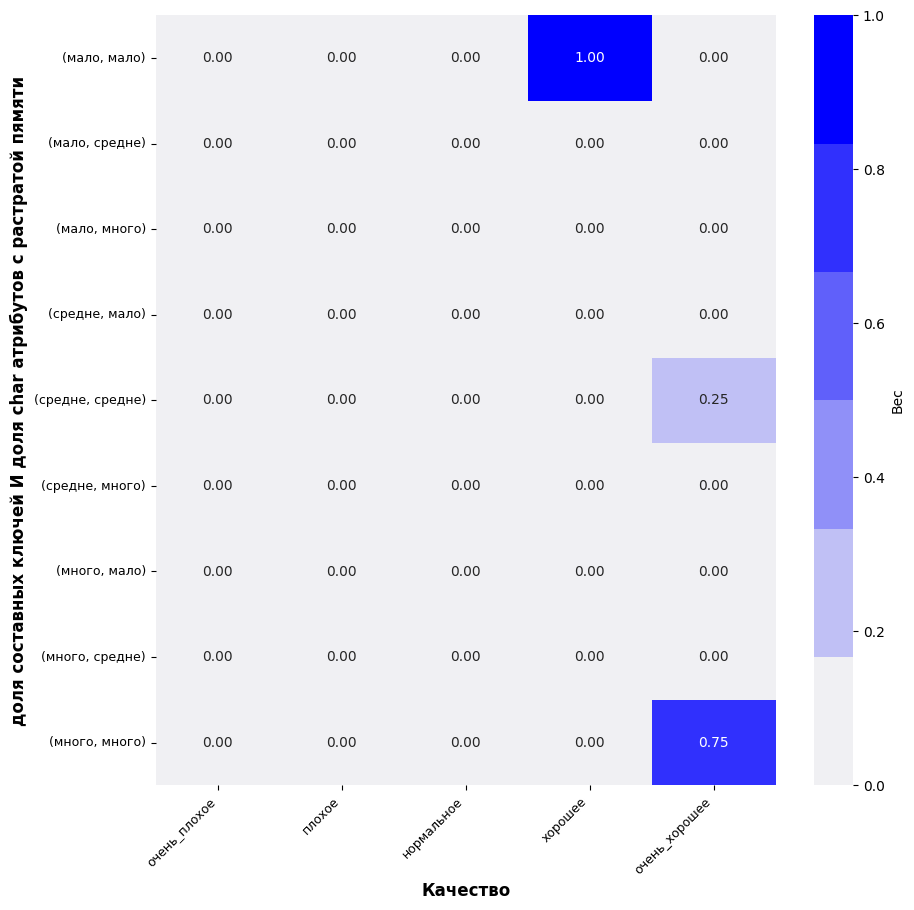

In [348]:
ax = parser.visualize_fuzzy_matrix(
    param_name='доля_составных_ключей_И_доля_char_атрибутов_с_растратой_пямяти',
    data=conjuction_matrices_df['доля_составных_ключей_И_доля_char_атрибутов_с_растратой_пямяти']
)
plt.show()

In [349]:
# Дополнение

# Создаём матрицу правил
matrix_df = dfs['доля_составных_ключей']
title = 'доля_составных_ключей'

print("\nИсходная матрица правил:")
print(matrix_df)

# Получаем дополнение для каждого элемента матрицы
matrix_complement = matrix_df.applymap(lambda x: 1 - x)

print("\nДополнение матрицы правил:")
print(matrix_complement)


Исходная матрица правил:
        очень_плохое  плохое  нормальное  хорошее  очень_хорошее
мало             0.0     0.0         0.0      0.0            0.5
средне           0.0     0.0         0.6      0.0            0.0
много            0.7     0.0         0.0      0.0            0.0

Дополнение матрицы правил:
        очень_плохое  плохое  нормальное  хорошее  очень_хорошее
мало             1.0     1.0         1.0      1.0            0.5
средне           1.0     1.0         0.4      1.0            1.0
много            0.3     1.0         1.0      1.0            1.0


/var/folders/0n/5qlwvd9d02n8kssx435yjb9c0000gp/T/ipykernel_45553/1719603780.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  matrix_complement = matrix_df.applymap(lambda x: 1 - x)


In [350]:
matrices = parser.get_relation_matrices()
matrices

{'доля_составных_ключей': {'input_terms': ['мало', 'средне', 'много'],
  'output_terms': ['очень_плохое',
   'плохое',
   'нормальное',
   'хорошее',
   'очень_хорошее'],
  'matrix': [[0.0, 0.0, 0.0, 0.0, 0.5],
   [0.0, 0.0, 0.6, 0.0, 0.0],
   [0.7, 0.0, 0.0, 0.0, 0.0]]},
 'доля_не_целочисленных_ключей': {'input_terms': ['мало', 'средне', 'много'],
  'output_terms': ['очень_плохое',
   'плохое',
   'нормальное',
   'хорошее',
   'очень_хорошее'],
  'matrix': [[0.0, 0.0, 0.0, 0.0, 0.6],
   [0.0, 0.0, 0.7, 0.0, 0.0],
   [0.8, 0.0, 0.0, 0.0, 0.0]]},
 'доля_char_атрибутов_с_растратой_пямяти': {'input_terms': ['мало',
   'средне',
   'много'],
  'output_terms': ['очень_плохое',
   'плохое',
   'нормальное',
   'хорошее',
   'очень_хорошее'],
  'matrix': [[0.0, 0.0, 0.0, 0.0, 0.75],
   [0.0, 0.0, 0.85, 0.0, 0.0],
   [0.95, 0.0, 0.0, 0.0, 0.0]]},
 'доля_таблиц_без_on_update': {'input_terms': ['мало', 'средне', 'много'],
  'output_terms': ['очень_плохое',
   'плохое',
   'нормальное',
   'хоро

In [351]:
transposed = parser.transpose_all_matrices(matrices)
transposed

{'доля_составных_ключей': {'input_terms': ['очень_плохое',
   'плохое',
   'нормальное',
   'хорошее',
   'очень_хорошее'],
  'output_terms': ['мало', 'средне', 'много'],
  'matrix': [[0.0, 0.0, 0.7],
   [0.0, 0.0, 0.0],
   [0.0, 0.6, 0.0],
   [0.0, 0.0, 0.0],
   [0.5, 0.0, 0.0]]},
 'доля_не_целочисленных_ключей': {'input_terms': ['очень_плохое',
   'плохое',
   'нормальное',
   'хорошее',
   'очень_хорошее'],
  'output_terms': ['мало', 'средне', 'много'],
  'matrix': [[0.0, 0.0, 0.8],
   [0.0, 0.0, 0.0],
   [0.0, 0.7, 0.0],
   [0.0, 0.0, 0.0],
   [0.6, 0.0, 0.0]]},
 'доля_char_атрибутов_с_растратой_пямяти': {'input_terms': ['очень_плохое',
   'плохое',
   'нормальное',
   'хорошее',
   'очень_хорошее'],
  'output_terms': ['мало', 'средне', 'много'],
  'matrix': [[0.0, 0.0, 0.95],
   [0.0, 0.0, 0.0],
   [0.0, 0.85, 0.0],
   [0.0, 0.0, 0.0],
   [0.75, 0.0, 0.0]]},
 'доля_таблиц_без_on_update': {'input_terms': ['очень_плохое',
   'плохое',
   'нормальное',
   'хорошее',
   'очень_хорошее

In [352]:
dfs_transposed = parser.matrices_to_dataframes(transposed)
parser.print_all_dataframes(dfs_transposed)

доля_составных_ключей
               мало  средне  много
очень_плохое    0.0     0.0    0.7
плохое          0.0     0.0    0.0
нормальное      0.0     0.6    0.0
хорошее         0.0     0.0    0.0
очень_хорошее   0.5     0.0    0.0

доля_не_целочисленных_ключей
               мало  средне  много
очень_плохое    0.0     0.0    0.8
плохое          0.0     0.0    0.0
нормальное      0.0     0.7    0.0
хорошее         0.0     0.0    0.0
очень_хорошее   0.6     0.0    0.0

доля_char_атрибутов_с_растратой_пямяти
               мало  средне  много
очень_плохое   0.00    0.00   0.95
плохое         0.00    0.00   0.00
нормальное     0.00    0.85   0.00
хорошее        0.00    0.00   0.00
очень_хорошее  0.75    0.00   0.00

доля_таблиц_без_on_update
               мало  средне  много
очень_плохое    0.0     0.0    0.9
плохое          0.0     0.0    0.0
нормальное      0.0     0.8    0.0
хорошее         0.0     0.0    0.0
очень_хорошее   0.7     0.0    0.0

доля_таблиц_без_on_delete
              

In [353]:
parser = RuleParser('rules.json')

In [354]:
parsed_rules = []

for rule_data in parser.rules_data:
    parsed_rule = parser.parse_rule_with_and(rule_data)
    parsed_rules.append(parsed_rule)
    print(parsed_rule)

{'is_valid': True, 'conditions': [{'parameter': 'доля_составных_ключей', 'term': 'мало'}], 'output_var': 'качество', 'output_term': 'очень_хорошее', 'weight': 0.5, 'error': None}
{'is_valid': True, 'conditions': [{'parameter': 'доля_составных_ключей', 'term': 'средне'}], 'output_var': 'качество', 'output_term': 'нормальное', 'weight': 0.6, 'error': None}
{'is_valid': True, 'conditions': [{'parameter': 'доля_составных_ключей', 'term': 'много'}], 'output_var': 'качество', 'output_term': 'очень_плохое', 'weight': 0.7, 'error': None}
{'is_valid': True, 'conditions': [{'parameter': 'доля_не_целочисленных_ключей', 'term': 'мало'}], 'output_var': 'качество', 'output_term': 'очень_хорошее', 'weight': 0.6, 'error': None}
{'is_valid': True, 'conditions': [{'parameter': 'доля_не_целочисленных_ключей', 'term': 'средне'}], 'output_var': 'качество', 'output_term': 'нормальное', 'weight': 0.7, 'error': None}
{'is_valid': True, 'conditions': [{'parameter': 'доля_не_целочисленных_ключей', 'term': 'мног

In [355]:
# input_data = {
#     'доля_составных_ключей': 0.1,
#     'доля_не_целочисленных_ключей': 0.2,
#     # 'доля_неатомарных_атрибутов': 0.4,
#     'доля_char_атрибутов_с_растратой_пямяти': 0.5,
#     'доля_таблиц_без_on_update': 0.3,
#     'доля_таблиц_без_on_delete': 0.6
# }

In [356]:
# input_data = {
#     'доля_составных_ключей': 0.6,
#     'доля_не_целочисленных_ключей': 0.6,
#     # 'доля_неатомарных_атрибутов': 0.4,
#     'доля_char_атрибутов_с_растратой_пямяти': 0.5,
#     'доля_таблиц_без_on_update': 0.6,
#     'доля_таблиц_без_on_delete': 0.6
# }

In [357]:
# input_data = {'доля_составных_ключей': 0.0,
#  'доля_не_целочисленных_ключей': 0.1,
# #  'доля_неатомарных_атрибутов': 0.0,
#  'доля_char_атрибутов_с_растратой_пямяти': 0.0,
#  'доля_таблиц_без_on_update': 1.0,
#  'доля_таблиц_без_on_delete': 1.0}

In [358]:
input_data = {
    'доля_составных_ключей': 0.0,
    'доля_не_целочисленных_ключей': 0.0,
    # 'доля_неатомарных_атрибутов': 0.4,
    'доля_char_атрибутов_с_растратой_пямяти': 0.0,
    'доля_таблиц_без_on_update': 0.0,
    'доля_таблиц_без_on_delete': 0.0
}

In [359]:
class Fuzzificator:
    def __init__(self, parser : RuleParser):
        self.parser = parser

    def fuzzify_input_data(self, input_data):
        output_data = {}

        for param_name, value in input_data.items():
            if param_name not in self.parser.all_fuzzy_sets:
                print(f"Параметр '{param_name}' не найден в all_fuzzy_sets")
                print(f"Доступные параметры: {list(self.parser.all_fuzzy_sets.keys())}")
                continue
            
            fuzzy_sets = self.parser.all_fuzzy_sets[param_name]
            output_data[param_name] = {}
            
            for term_name, fuzzy_set in fuzzy_sets.items():
                membership = fuzzy_set.func(fuzzy_set.func_params, value)
                output_data[param_name][term_name] = round(membership, 3)
        
        return output_data

    def fuzzify_final_output(self, x : int):
        fuzzy_out = {}
        fuzzy_sets = self.parser.quality
        for k, v in fuzzy_sets.items():
            fuzzy_out[k] = fuzzy_sets[k].func(fuzzy_sets[k].func_params, x)
        return fuzzy_out
    
    def beautiful_output(self, fuzzy_out):
        max_out = 0
        k_max_out = ''
        for k, v in fuzzy_out.items():
            if max_out < v:
                max_out = v
                k_max_out = k
        return f'Качество БД - {k_max_out}'


In [360]:
class Summarizer:
    def __init__(self, fuzzificator):
        self.fuzzificator = fuzzificator

    def activation(self, rule, fuzzified_input):
        if not rule.get('is_valid', False):
            return 0.0
        
        if not rule.get('conditions'):
            return 0.0
        
        # Получаем значения для каждого условия
        condition_values = []
        
        for condition in rule['conditions']:
            param_name = condition['parameter'].strip().lower()
            term_name = condition['term'].strip().lower()
            
            # Ищем параметр в входных данных
            param_found = None
            for param_key in fuzzified_input.keys():
                if param_key.lower() == param_name:
                    param_found = param_key
                    break
            
            if param_found is None:
                return 0.0
            
            # Ищем терм в параметре
            term_found = None
            for term_key in fuzzified_input[param_found].keys():
                if term_key.lower() == term_name:
                    term_found = term_key
                    break
            
            if term_found is None:
                return 0.0
            
            # Получаем степень принадлежности
            membership = fuzzified_input[param_found][term_found]
            condition_values.append(membership)
        
        # Активация = min всех условий
        activation_val = min(condition_values) if condition_values else 0.0
        
        return activation_val
    
    def aggregation(self, activation_results):
        extra_points = []
        for set_k, set_v in activation_results.items():
            cur_alpha = max(activation_results.get(set_k, None))
            self.fuzzificator.parser.quality[set_k].set_alpha(cur_alpha)
            extra_points += self.fuzzificator.parser.quality[set_k].set_extra_points(alpha=cur_alpha)
        return extra_points

    def visualize_sets(self):
        quality_data = self.fuzzificator.parser.quality
        plt.figure(figsize=(16, 8))
        colors_dict = {
            'очень_плохое': "#4E0404",
            'плохое': '#FF6B6B',
            'нормальное': '#FFD93D',
            'хорошее': "#D0E300",
            'очень_хорошее': '#6BCB77'
        }
        
        for i, data in quality_data.items():
            color = colors_dict[i]
            if not data:
                continue
            name = i
            x_range = quality_data[i].x_range
            y_range = quality_data[i].y_range
            
            
            plt.plot(x_range, y_range, 
                    label=name, 
                    color=color, 
                    linewidth=2)

        plt.xlabel('x', fontsize=12)
        plt.ylabel('y', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        plt.show()

In [361]:
class Defuzzificator:
    def __init__(self, summarizer):
        self.quality_term_data = summarizer.fuzzificator.parser.quality

    def _find_funcs_intersections(self, tolerance=1e-6):
        quality_funcs = {}
        for term_name, fuzzy_set in self.quality_term_data.items():
            if fuzzy_set.x_range is not None and fuzzy_set.y_range is not None:
                quality_funcs[term_name] = {
                    'x': fuzzy_set.x_range,
                    'y': fuzzy_set.y_range
                }
        
        if len(quality_funcs) < 2:
            print(f"Недостаточно функций для поиска пересечений: {len(quality_funcs)}")
            return []
        
        # ШАГ 2: Интерполируем все функции
        interpolated_funcs = {}
        for term_name, data in quality_funcs.items():
            interpolated_funcs[term_name] = interpolate.interp1d(
                data['x'], data['y'], kind='linear', 
                bounds_error=False, fill_value=0
            )
        
        # ШАГ 3: Ищем пересечения между всеми парами функций
        intersections = []
        func_names = list(interpolated_funcs.keys())
        
        for i in range(len(func_names)):
            for j in range(i + 1, len(func_names)):
                name1 = func_names[i]
                name2 = func_names[j]
                f1 = interpolated_funcs[name1]
                f2 = interpolated_funcs[name2]
                
                # Определяем диапазон поиска
                x1_min, x1_max = quality_funcs[name1]['x'].min(), quality_funcs[name1]['x'].max()
                x2_min, x2_max = quality_funcs[name2]['x'].min(), quality_funcs[name2]['x'].max()
                
                x_min = max(x1_min, x2_min)
                x_max = min(x1_max, x2_max)
                
                if x_max <= x_min:
                    continue  # Нет пересечения по диапазону
                
                # Разность функций
                def difference(x):
                    return f1(x) - f2(x)
                
                # Грубый поиск: ищем смены знака
                x_coarse = np.linspace(x_min, x_max, 100)
                y_diff = [difference(x) for x in x_coarse]
                
                # Для каждой смены знака применяем бинарный поиск
                for k in range(len(y_diff) - 1):
                    if y_diff[k] * y_diff[k+1] < 0:  # Смена знака
                        
                        # Бинарный поиск
                        a = x_coarse[k]
                        b = x_coarse[k+1]
                        
                        while abs(b - a) > tolerance:
                            mid = (a + b) / 2
                            
                            if difference(a) * difference(mid) < 0:
                                b = mid
                            else:
                                a = mid
                        
                        x_intersect = float((a + b) / 2)
                        y_intersect = float(f1(x_intersect))
                        
                        intersections.append([round(float(x_intersect), 2), round(float(y_intersect), 2)])
        
        print(f"Найдено {len(intersections)} пересечений между функциями")
        for idx, (x, y) in enumerate(intersections, 1):
            print(f"   [{idx}] x={x:.3f}, y={y:.3f}")
        
        return intersections

    def _get_all_funcs_points(self):
        all_points_data = []
        for set in self.quality_term_data:
            for i in range(len(self.quality_term_data[set].x_range)):
                x = self.quality_term_data[set].x_range[i]
                y = self.quality_term_data[set].y_range[i]
                all_points_data.append((x, y))

        return all_points_data

    def set_outer_points(self):
        all_points_data = self._get_all_funcs_points()
        intersections = self._find_funcs_intersections()
        all_points_data += intersections
        # print(all_points_data)
        outer_points = defaultdict()
        for x, y in all_points_data:
            if x not in outer_points.keys() or x in outer_points.keys() and y > outer_points[x]:
                outer_points[x] = y

        self.outer_points = tuple(outer_points.items())

        return list(intersections)
    
    def find_x_axis_intersections(self):
        points = self.outer_points
        intersections = []

        if not points or len(points) < 2:
            return intersections

        # проверяем пары соседей
        for (x1, y1), (x2, y2) in zip(points[:-1], points[1:]):
            # точка на оси X
            if y1 == 0:
                intersections.append([round(float(x1), 2), 0.0])

            # сегмент полностью на оси X
            if y1 == 0 and y2 == 0:
                intersections.append([round(float(x2), 2), 0.0])
            # пересечение по смене знака
            elif y1 * y2 < 0:
                t = -y1 / (y2 - y1)
                x = x1 + t * (x2 - x1)
                intersections.append([round(float(x), 2), 0.0])

        # отдельно проверяем ПОСЛЕДНЮЮ точку
        last_x, last_y = points[-1]
        if last_y == 0:
            intersections.append([round(float(last_x), 2), 0.0])

        # убираем дубли
        # intersections = set(intersections)
        return intersections

    def get_gravity_center(self, points):
        n = len(points)
        sum_x = 0
        sum_y = 0
        for x, y in points:
            sum_x += x
            sum_y += y

        target_x, target_y = round(float(sum_x)/n, 3), round(float(sum_y)/n, 3)
        
        return [target_x, target_y]
    
    def visualize_polygon(self, vertices=None, centroid=None):
        x_range = []
        y_range = []
        points_x_y = self.outer_points

        plt.figure(figsize=(12, 8))
        color = "#1900FF"
        
        for x, y in points_x_y:
            x_range.append(x)
            y_range.append(y)

        plt.axhline(0, color='black', linewidth=1)  # ось X
        plt.axvline(0, color='black', linewidth=1)  # ось Y
        plt.plot(x_range, y_range, color=color, linewidth=2)

        if vertices:
            vx = [p[0] for p in vertices]
            vy = [p[1] for p in vertices]
            plt.scatter(vx, vy, color='green', s=40, zorder=5)

        if centroid is not None:
            cx, cy = centroid
            plt.scatter([cx], [cy], color='red', s=70, marker='x', zorder=6, label='Центр масс')
            plt.text(cx, cy, f"  ({cx:.3f}, {cy:.3f})", color='red', va='top')

        plt.xlabel('x', fontsize=12)
        plt.ylabel('y', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()

In [362]:
fuzzificator = Fuzzificator(parser)

In [363]:
output_data = fuzzificator.fuzzify_input_data(input_data)
output_data

{'доля_составных_ключей': {'мало': 0.0, 'средне': 0.0, 'много': 0.0},
 'доля_не_целочисленных_ключей': {'мало': 0.0, 'средне': 0.0, 'много': 0.0},
 'доля_char_атрибутов_с_растратой_пямяти': {'мало': 0.0,
  'средне': 0.0,
  'много': 0.0},
 'доля_таблиц_без_on_update': {'мало': 0.0, 'средне': 0.0, 'много': 0.0},
 'доля_таблиц_без_on_delete': {'мало': 0.0, 'средне': 0.0, 'много': 0.0}}

In [364]:
summarizer = Summarizer(fuzzificator=fuzzificator)

In [365]:
min_by_rule = {}

for parsed_rule in parsed_rules:
    min_rule_val = summarizer.activation(rule=parsed_rule, fuzzified_input=output_data)
    term = parsed_rule['output_term']
    if term in min_by_rule.keys():
        min_by_rule[term].append(min_rule_val)
    else:
        min_by_rule[term] = [min_rule_val]
        print(term, min_rule_val)

очень_хорошее 0.0
нормальное 0.0
очень_плохое 0.0
хорошее 0.0
плохое 0.0


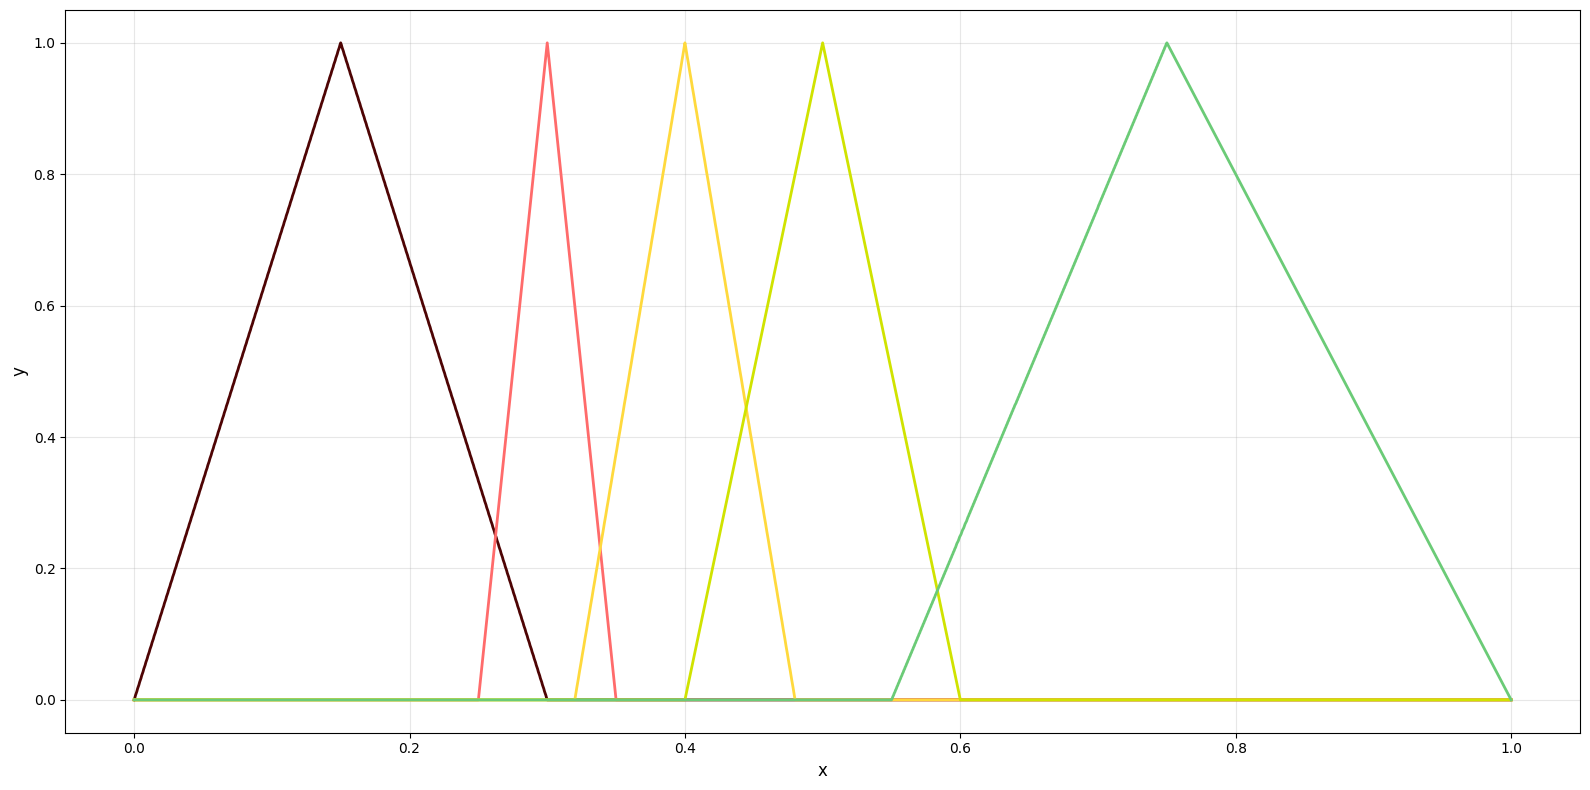

In [366]:
summarizer.visualize_sets()

In [367]:
extra_points = summarizer.aggregation(min_by_rule)

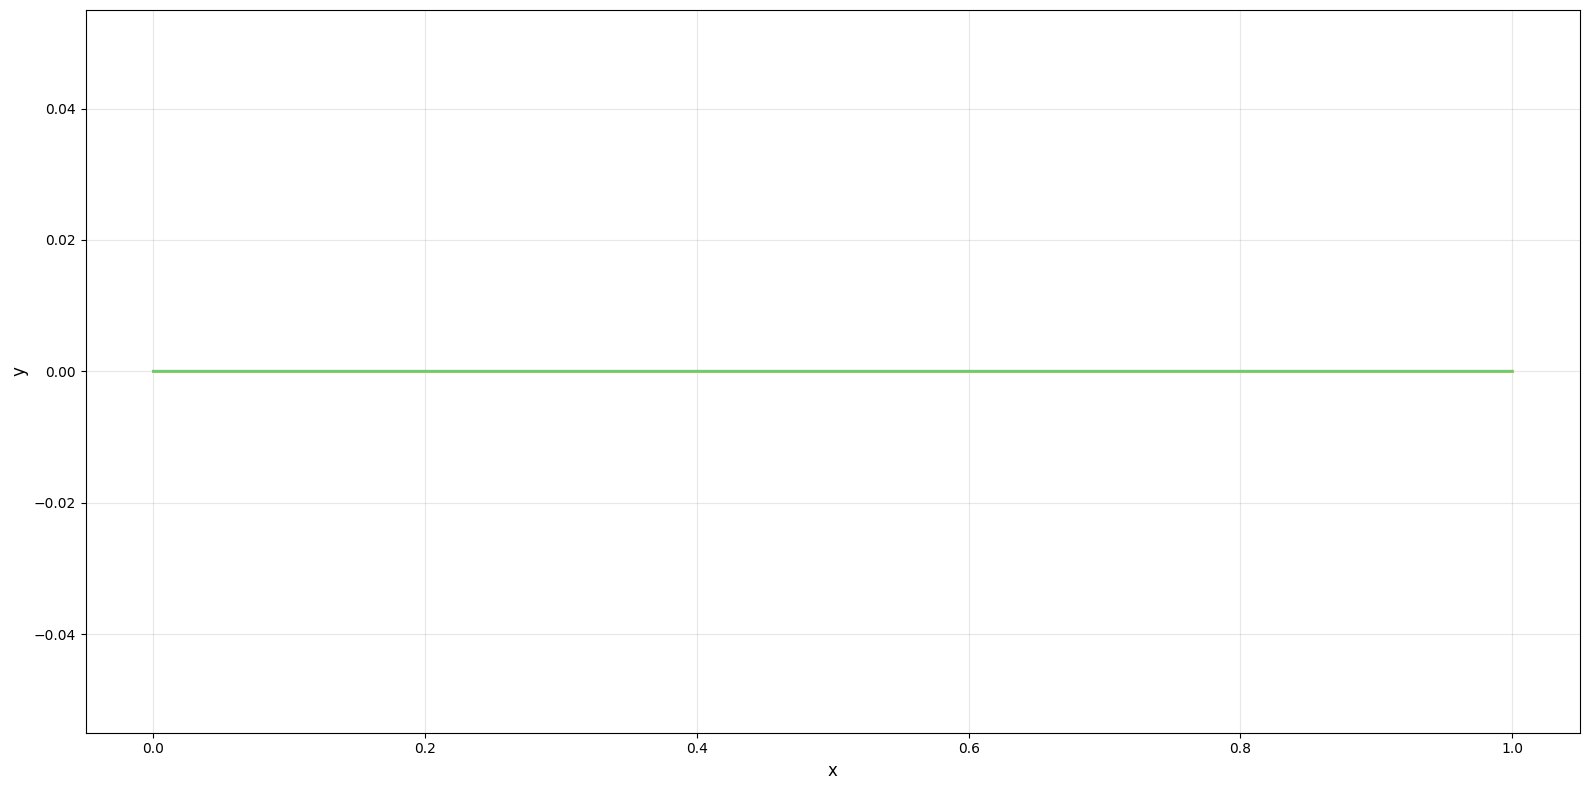

In [368]:
summarizer.visualize_sets()

In [369]:
defuzzificator = Defuzzificator(summarizer=summarizer)

In [370]:
intersections = defuzzificator.set_outer_points()
intersections

Найдено 0 пересечений между функциями


[]

/var/folders/0n/5qlwvd9d02n8kssx435yjb9c0000gp/T/ipykernel_45553/2328450918.py:178: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


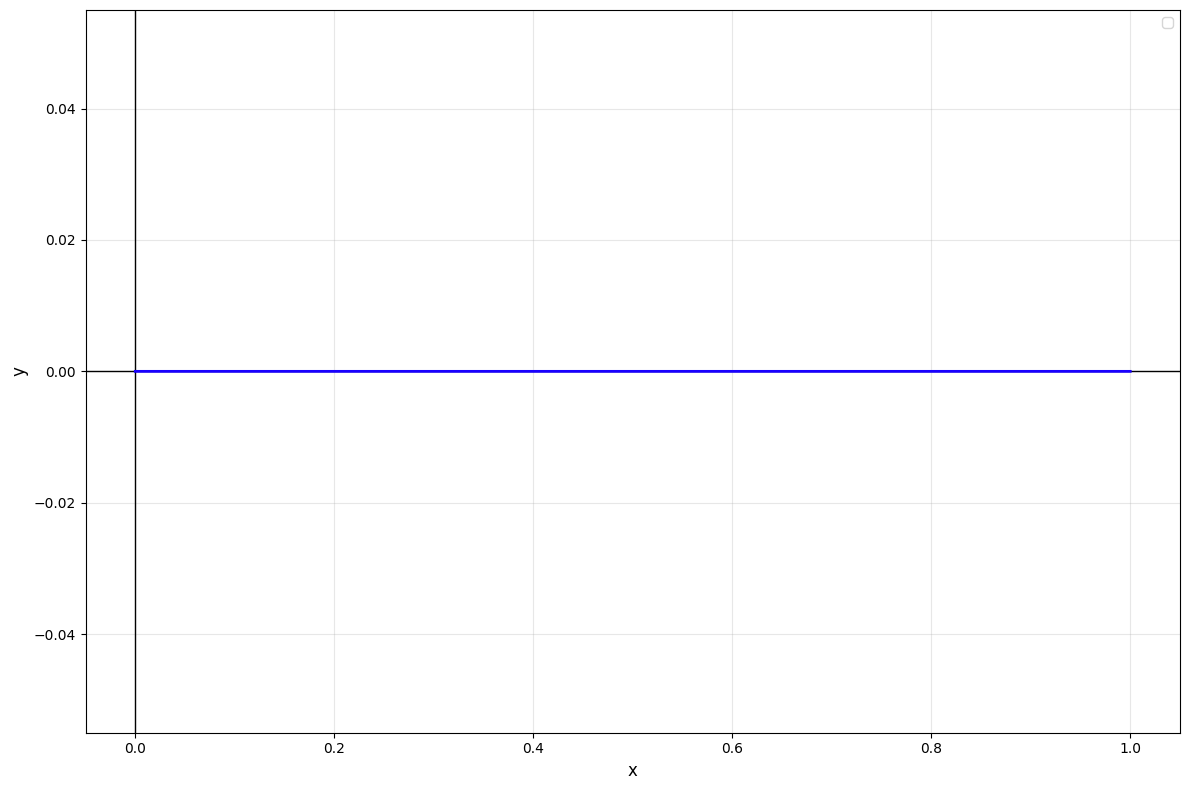

In [371]:
defuzzificator.visualize_polygon()

In [372]:
x_intersections = defuzzificator.find_x_axis_intersections()

In [373]:
polygon_vertices = x_intersections
polygon_vertices += intersections
polygon_vertices += extra_points
polygon_vertices

[[0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.0, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.01, 0.0],
 [0.02, 0.0],
 [0.02, 0.0],
 [0.02, 0.0],
 [0.02, 0.0],
 [0.02, 0.0],
 [0.02, 0.0],
 [0.02, 0.0],
 [0.02, 0.0],
 [0.02, 0.0],
 [0.02, 0.0],
 [0.02, 0.0],
 [0.02, 0.0

/var/folders/0n/5qlwvd9d02n8kssx435yjb9c0000gp/T/ipykernel_45553/2328450918.py:178: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


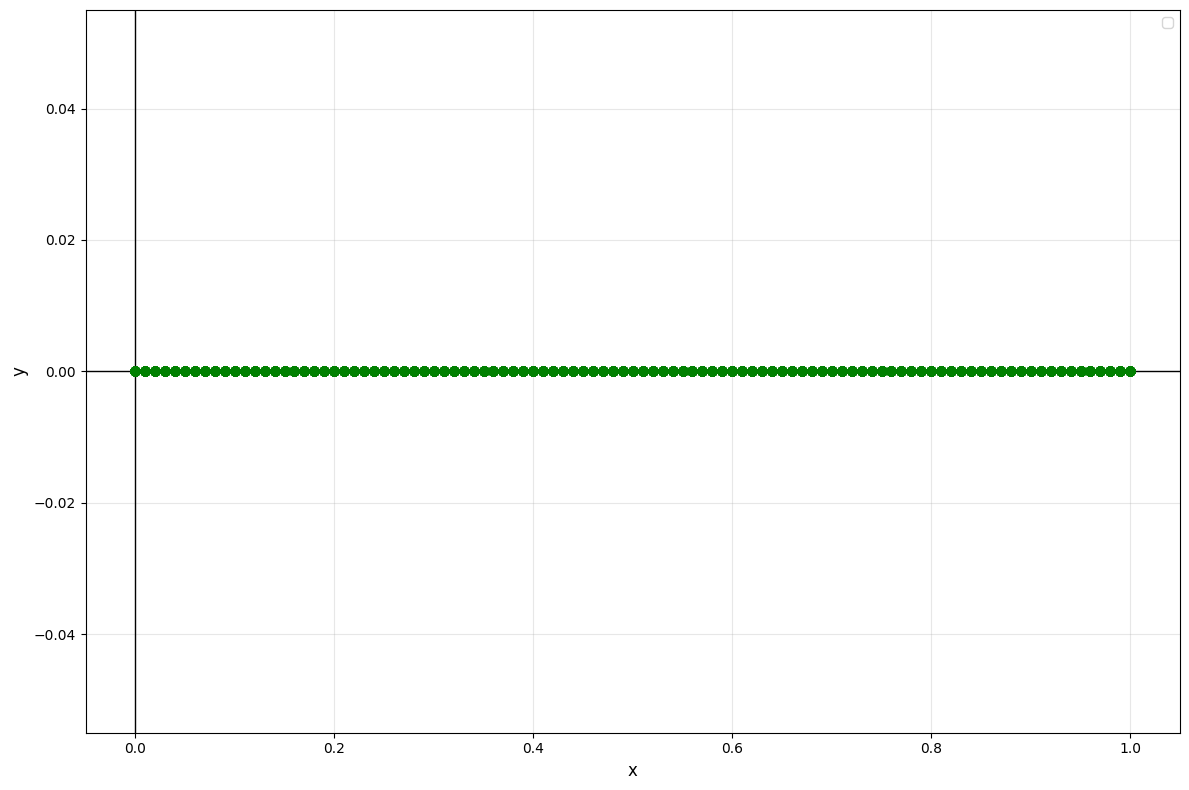

In [374]:
defuzzificator.visualize_polygon(vertices=polygon_vertices)

In [375]:
target = defuzzificator.get_gravity_center(polygon_vertices)
target

[0.5, 0.0]

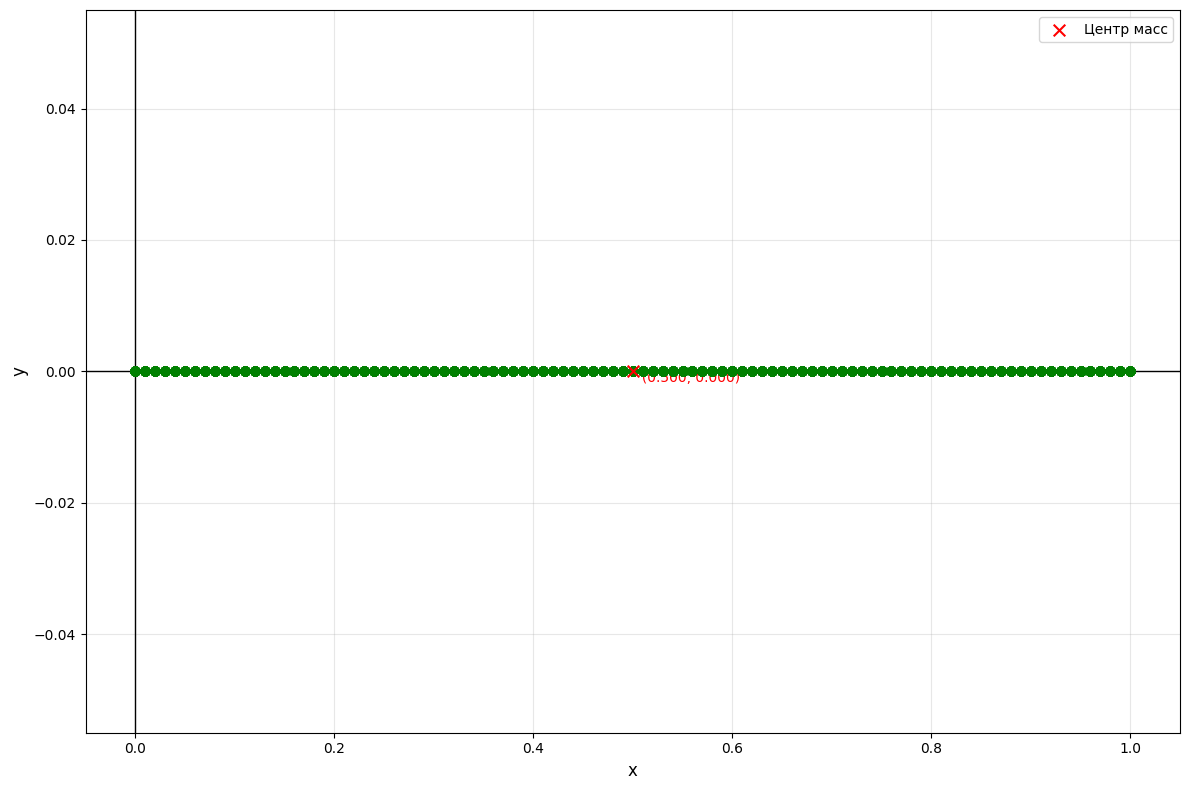

In [376]:
defuzzificator.visualize_polygon(vertices=polygon_vertices, centroid=target)

In [377]:
x = target[0]
fuzzy_out = fuzzificator.fuzzify_final_output(x)
fuzzy_out

{'очень_плохое': 0.0,
 'плохое': 0.0,
 'нормальное': 0.0,
 'хорошее': 1.0,
 'очень_хорошее': 0.0}

In [378]:
fuzzificator.beautiful_output(fuzzy_out)

'Качество БД - хорошее'